<a href="https://colab.research.google.com/github/mananverma29-oss/ai-sales-insights-aws/blob/main/python_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyathena pandas requests python-dotenv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
# install dependencies
from pyathena import connect
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import os

os.environ["AWS_ACCESS_KEY_ID"] = "-----6ZK7GJJEQK2"
os.environ["AWS_SECRET_ACCESS_KEY"] = "-----RnDLgKNH1Lb5OfM"
os.environ["AWS_DEFAULT_REGION"] = "ap-southeast-2"  # or your actual region

In [ ]:
                 # or your region
S3_STAGING_DIR = "s3://projectbucket-mananverma5yexp/athena_staging/"   # Athena query results
DATABASE = "sales_db"

def run_athena(query):
    conn = connect(region_name=AWS_REGION, s3_staging_dir=S3_STAGING_DIR, schema_name=DATABASE)
    df = pd.read_sql(query, conn)
    conn.close()
    return df

In [ ]:
df_stats = run_athena("""
SELECT COUNT(*) as rows, MIN(order_date) as min_order_date, MAX(order_date) as max_order_date FROM sales_data
""")
print(df_stats.to_dict(orient='records'))

/tmp/ipython-input-3863522311.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


[{'rows': 9994, 'min_order_date': '2014-01-03', 'max_order_date': '2017-12-30'}]


In [ ]:
# monthly customers
monthly_q = """
SELECT
  date_trunc('month', cast(order_date AS date)) AS month,
  SUM(CAST(sales AS DOUBLE)) AS total_sales,
  SUM(CAST(profit AS DOUBLE)) AS total_profit,
  COUNT(DISTINCT customer_id) AS customers
FROM sales_data_fixed
GROUP BY 1
ORDER BY 1
"""
df_monthly = run_athena(monthly_q)
print(df_monthly)

/tmp/ipython-input-3207606086.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


         month  total_sales  total_profit  customers
0   2014-01-01   14236.8950     2450.1907         32
1   2014-02-01    4519.8920      862.3084         27
2   2014-03-01   55691.0090      498.7299         69
3   2014-04-01   28295.3450     3488.8352         64
4   2014-05-01   23648.2870     2738.7096         67
5   2014-06-01   34595.1276     4976.5244         63
6   2014-07-01   33946.3930     -841.4826         65
7   2014-08-01   27909.4685     5318.1050         70
8   2014-09-01   81777.3508     8328.0994        118
9   2014-10-01   31453.3930     3448.2573         75
10  2014-11-01   78628.7167     9292.1269        139
11  2014-12-01   69545.6205     8983.5699        134
12  2015-01-01   18174.0756    -3281.0070         28
13  2015-02-01   11951.4110     2813.8508         36
14  2015-03-01   38726.2520     9732.0978         77
15  2015-04-01   34195.2085     4187.4962         69
16  2015-05-01   30131.6865     4667.8690         69
17  2015-06-01   24797.2920     3335.5572     

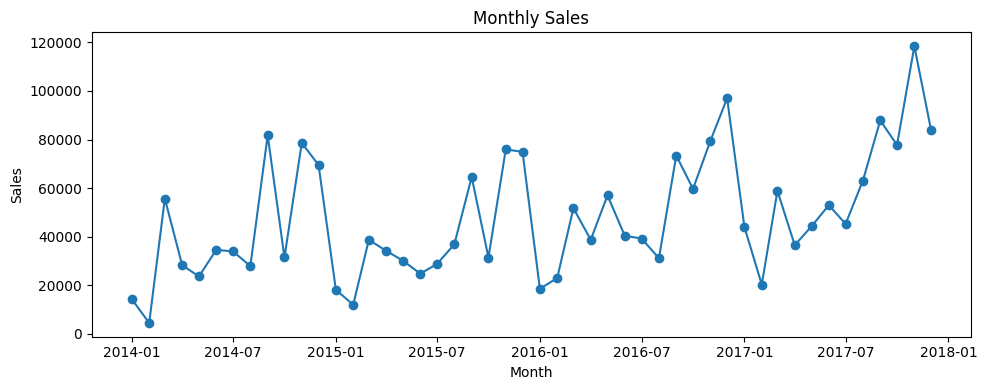

In [ ]:
#plotting monthly



plt.figure(figsize=(10,4))
plt.plot(df_monthly['month'], df_monthly['total_sales'], marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month'); plt.ylabel('Sales')
plt.tight_layout(); plt.savefig(f"monthly_sales.png"); plt.show()

/tmp/ipython-input-3207606086.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


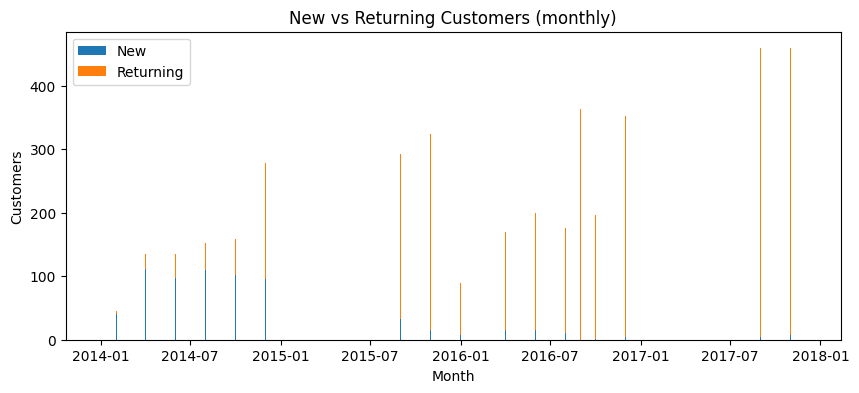

In [ ]:
# ---------- 2. New vs Returning Customers (monthly) ----------
new_returning_q = """
WITH first_purchase AS (
  SELECT customer_id, MIN(cast(order_date AS date)) AS first_order_date
  FROM sales_data
  GROUP BY customer_id
)
SELECT
  date_trunc('month', cast(s.order_date AS date)) AS month,
  SUM(CASE WHEN cast(s.order_date AS date) = fp.first_order_date THEN 1 ELSE 0 END) AS new_customers,
  SUM(CASE WHEN cast(s.order_date AS date) > fp.first_order_date THEN 1 ELSE 0 END) AS returning_customers
FROM sales_data s
JOIN first_purchase fp
  ON s.customer_id = fp.customer_id
GROUP BY 1
ORDER BY 1;
"""
df_nr = run_athena(new_returning_q)
df_nr['month'] = pd.to_datetime(df_nr['month'])


plt.figure(figsize=(10,4))
plt.bar(df_nr['month'], df_nr['new_customers'], label='New')
plt.bar(df_nr['month'], df_nr['returning_customers'], bottom=df_nr['new_customers'], label='Returning')
plt.legend(); plt.title('New vs Returning Customers (monthly)')
plt.xlabel('Month'); plt.ylabel('Customers')
plt.savefig(f"new_returning.png"); plt.show()

/tmp/ipython-input-3863522311.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


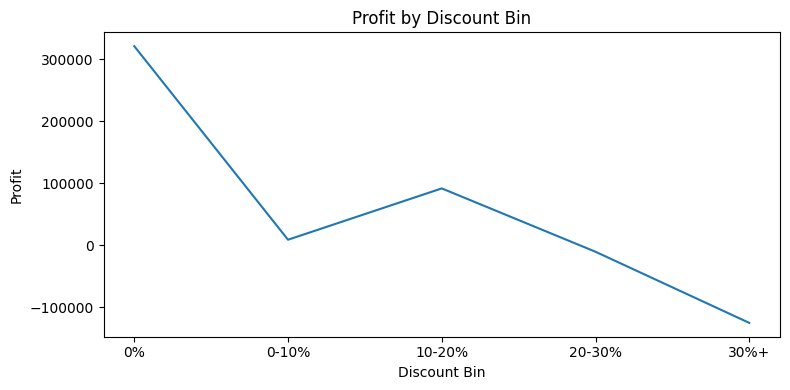

In [ ]:
# ---------- 4. Discount effectiveness ----------
discount_q = """
SELECT discount_bin,
       SUM(CAST(sales AS DOUBLE)) AS sales,
       SUM(CAST(profit AS DOUBLE)) AS profit,
       (SUM(CAST(profit AS DOUBLE))/NULLIF(SUM(CAST(sales AS DOUBLE)),0)) AS profit_pct
FROM (
  SELECT *,
    CASE
      WHEN discount IS NULL THEN 'unknown'
      WHEN CAST(discount AS DOUBLE) = 0 THEN '0%'
      WHEN CAST(discount AS DOUBLE) > 0 AND CAST(discount AS DOUBLE) <= 0.1 THEN '0-10%'
      WHEN CAST(discount AS DOUBLE) > 0.1 AND CAST(discount AS DOUBLE) <= 0.2 THEN '10-20%'
      WHEN CAST(discount AS DOUBLE) > 0.2 AND CAST(discount AS DOUBLE) <= 0.3 THEN '20-30%'
      ELSE '30%+'
    END AS discount_bin
  FROM sales_data
)
GROUP BY discount_bin
ORDER BY
  CASE discount_bin
    WHEN '0%' THEN 1 WHEN '0-10%' THEN 2 WHEN '10-20%' THEN 3
    WHEN '20-30%' THEN 4 WHEN '30%+' THEN 5 ELSE 6 END;
"""
df_discount = run_athena(discount_q)


plt.figure(figsize=(8,4))
plt.plot(df_discount['discount_bin'], df_discount['profit'])
plt.title('Profit by Discount Bin'); plt.xlabel('Discount Bin'); plt.ylabel('Profit')
plt.tight_layout(); plt.savefig(f"discount_profit.png"); plt.show()

/tmp/ipython-input-3863522311.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


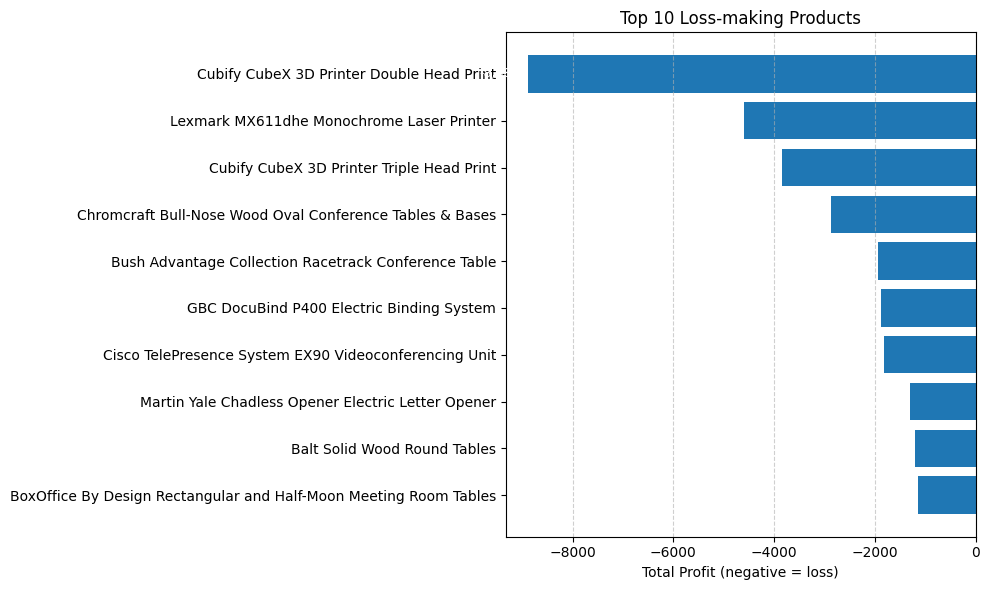

Saved top10_loss_making_products.png and CSV.


In [ ]:
# top 10 loss making products'


sql = """
SELECT
  COALESCE(product_name, product_id) AS product,
  SUM(CAST(profit AS DOUBLE)) AS total_profit,
  SUM(CAST(sales AS DOUBLE)) AS total_sales,
  SUM(CAST(quantity AS DOUBLE)) AS total_qty
FROM sales_data
GROUP BY COALESCE(product_name, product_id)
HAVING SUM(CAST(profit AS DOUBLE)) < 0
ORDER BY total_profit ASC
LIMIT 10;
"""

df_top_losses = run_athena(sql)

# If no rows returned, handle gracefully
if df_top_losses.empty:
    print("No loss-making products found (query returned 0 rows).")
else:
    # Ensure product column is string and profit numeric
    df_top_losses['product'] = df_top_losses['product'].astype(str)
    df_top_losses['total_profit'] = df_top_losses['total_profit'].astype(float)

    # Sort so the largest loss (most negative) is at top
    df_top_losses = df_top_losses.sort_values('total_profit')  # ascending, most negative first

    # 2) Plot horizontal bar chart
    plt.figure(figsize=(10,6))
    y = df_top_losses['product']
    x = df_top_losses['total_profit']
    bars = plt.barh(y, x)
    plt.gca().invert_yaxis()  # biggest loss at top
    plt.xlabel('Total Profit (negative = loss)')
    plt.title('Top 10 Loss-making Products')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Annotate bars with profit values (formatted)
    for bar in bars:
        w = bar.get_width()
        plt.text(w - (0.02 * max(abs(x.min()), abs(x.max()))),
                 bar.get_y() + bar.get_height()/2,
                 f"{w:,.0f}", va='center', ha='right', color='white', fontsize=9)

    plt.tight_layout()
    plt.savefig('top10_loss_making_products.png', dpi=150)
    plt.show()

/tmp/ipython-input-3863522311.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


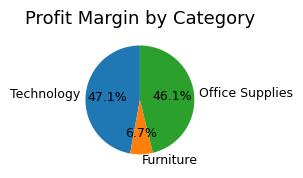

In [ ]:
sql = """
SELECT
  COALESCE(category, 'Unknown') AS category,
  SUM(CAST(sales AS DOUBLE)) AS total_sales,
  SUM(CAST(profit AS DOUBLE)) AS total_profit
FROM sales_data
GROUP BY COALESCE(category, 'Unknown')
ORDER BY total_sales DESC;
"""

df = run_athena(sql)
df['profit_margin_pct'] = (df['total_profit'] / df['total_sales']) * 100

# --- 3. Plot pie chart ---
plt.figure(figsize=(3,3))
plt.pie(
    df['profit_margin_pct'],
    labels=df['category'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 9}
)

plt.title('Profit Margin by Category', fontsize=13)
plt.tight_layout()
plt.show()
